In [1]:
import numpy as np 
import pandas as pd
import os


In [34]:
from keras.utils import Sequence
from keras.layers import Layer,Bidirectional,LSTM,Input,Reshape
import keras

In [3]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=897d6fc4a2bfcb14f26d9fcbea703b2d0c81022bfb0221dae44c9012cfa8467b
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [37]:
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential,Model
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization


In [7]:
dir = "../input/handwriting-recognition/train_v2/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [9]:
val_dir = "../input/handwriting-recognition/validation_v2/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])


In [10]:
train=pd.read_csv('../input/handwriting-recognition/written_name_train_v2.csv')
validation=pd.read_csv('../input/handwriting-recognition/written_name_validation_v2.csv')

In [11]:
train.dropna(inplace=True)

In [12]:
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=21]
train['IDENTITY']=train['IDENTITY'].str.upper()
train[train['Length']==max(train['Length'])]

,FILENAME,IDENTITY,Length
10278,TRAIN_10279.jpg,DOSSANTOS LASCONCELOS,21
108567,TRAIN_108568.jpg,O ZUARRDI EREBEVITRAC,21
156500,TRAIN_156501.jpg,ANDRIANNARISOA--DEGHI,21
160575,TRAIN_160576.jpg,LOUISIANE - EVANGELIN,21
174121,TRAIN_174122.jpg,GU ILLOSSOO - OARRIBA,21
212583,TRAIN_212584.jpg,DE MALEZIEUX DU HAMEL,21
220135,TRAIN_220136.jpg,COSTREL DE CORAINVILL,21
229529,TRAIN_229530.jpg,ROUSSEAV -- CHAUDIERE,21
230011,TRAIN_230012.jpg,BEKNARD DE LAVERNETTE,21
308769,TRAIN_308770.jpg,DATE NAISSANCE CLASSE,21


In [13]:
train=train.sample(frac=0.8,random_state=42)
validation=validation.sample(frac=0.1)


In [14]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)


In [15]:
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}

In [16]:
path_train='../input/handwriting-recognition/train_v2/train'
path_validation='../input/handwriting-recognition/validation_v2/validation'

In [19]:
class DataGenerator(Sequence):
    def __init__(self,dataframe,path,char_map,batch_size=128,img_size=(256,64),
                 downsample_factor=4,max_length=22,shuffle=True):
        self.dataframe=dataframe
        self.path=path
        self.char_map=char_map
        self.batch_size=batch_size
        self.width=img_size[0]
        self.height=img_size[1]
        self.downsample_factor=downsample_factor
        self.max_length=max_length
        self.shuffle=shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.dataframe)//self.batch_size
    
    def __getitem__(self,idx):
        curr_batch_idx=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images=np.ones((self.batch_size,self.width,self.height,1),dtype=np.float32)
        batch_labels=np.ones((self.batch_size,self.max_length),dtype=np.float32)
        input_length=np.ones((self.batch_size,1),dtype=np.float32)*(self.width//self.downsample_factor-2)
        label_length=np.zeros((self.batch_size,1),dtype=np.int64)
        for i,idx in enumerate(curr_batch_idx):
            img_path=self.dataframe['FILENAME'].values[idx]
            img=cv2.imread(self.path+'/'+img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(self.width,self.height))
            img=(img/255).astype(np.float32)
            img=img.T
            img=np.expand_dims(img,axis=-1)
            text=self.dataframe['IDENTITY'].values[idx]
            text=str(text)
            label=[]
            for j in text: 
                if j in self.char_map :
                    label.append(self.char_map[j])
                else:
                    label.append(100)
            label.extend([100]*(22-len(label)))
            batch_images[i]=img
            batch_labels[i]=label
            label_length[i]=len(label)
        batch_inputs= {
                'input_data':batch_images,
                'input_label':batch_labels,
                'input_length':input_length,
                'label_length':label_length
                
            }
        return batch_inputs,np.zeros((self.batch_size),dtype=np.float32)
    def on_epoch_end(self):
        if self.shuffle == True :
            np.random.shuffle(self.indices)
        

In [20]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_validation,char_to_label)

In [24]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return loss


In [31]:
def make_model():
    inp=Input(shape=(256,64,1),dtype=np.float32,name='input_data')
    labels=Input(shape=[22],dtype=np.float32,name='input_label')
    input_length=Input(shape=[1],dtype=np.int64,name='input_length')
    label_length=Input(shape=[1],dtype=np.int64,name='label_length')
    x=Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(inp)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.3)(x)
    x=Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.3)(x)
    new_shape=((256//4),(64//4)*128)
    x=Reshape(new_shape)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))(x)
    x=Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(x)
    x=Dense(len(characters)+1,activation='softmax',kernel_initializer='he_normal',name='Dense_output')(x)
    output=CTCLayer(name='outputs')(labels,x,input_length,label_length)
    model=Model([inp,labels,input_length,label_length],output)
    sgd = keras.optimizers.SGD(learning_rate=0.002,decay=1e-6,momentum=0.9,nesterov=True,clipnorm=5)
    model.compile(optimizer=sgd)
    return model

In [38]:
model=make_model()

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 64, 64)  640         input_data[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 32, 64)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 128, 32, 64)  0           max_pooling2d_6[0][0]            
______________________________________________________________________________________________

In [44]:
 history = model.fit(train_generator,steps_per_epoch=600,validation_data=validation_generator,epochs=8)

Epoch 1/8
600/600 [==============================] - 704s 1s/step - loss: 20.0343 - val_loss: 19.7403
Epoch 2/8
600/600 [==============================] - 509s 849ms/step - loss: 19.2054 - val_loss: 18.5962
Epoch 3/8
600/600 [==============================] - 390s 650ms/step - loss: 18.0170 - val_loss: 17.0856
Epoch 4/8
600/600 [==============================] - 321s 535ms/step - loss: 15.8852 - val_loss: 13.9287
Epoch 5/8
600/600 [==============================] - 265s 441ms/step - loss: 13.2010 - val_loss: 11.1881
Epoch 6/8
600/600 [==============================] - 232s 387ms/step - loss: 10.6242 - val_loss: 8.6634
Epoch 7/8
600/600 [==============================] - 209s 348ms/step - loss: 8.6222 - val_loss: 6.6209
Epoch 8/8
600/600 [==============================] - 200s 333ms/step - loss: 7.1255 - val_loss: 5.4454


In [46]:
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += label_to_char[c]
        output_text.append(outstr)
    return output_text

In [49]:
label_to_char[100]=''

In [50]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='Dense_output').output)

In [52]:
for p, (inp_value, _) in enumerate(validation_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    preds =prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([label_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Ground truth: EMPTY 	 Predicted: MOSSSS
Ground truth: LOUIS 	 Predicted: LOUIS
Ground truth: MATTEO 	 Predicted: MATTEO
Ground truth: TILLY 	 Predicted: TILLY
Ground truth: MATHIS 	 Predicted: MATHIS
Ground truth: HUBY 	 Predicted: AOY
Ground truth: AURORE 	 Predicted: AURORE
Ground truth: ELINA 	 Predicted: ELIVA
Ground truth: CANILLE 	 Predicted: CAMILLE
Ground truth: BAH 	 Predicted: DAM
Ground truth: RUGGERI 	 Predicted: AGOIRI
Ground truth: OLIVIER 	 Predicted: GLVIER
Ground truth: BRISSON 	 Predicted: BASSSON
Ground truth: BELZONS 	 Predicted: BELIONS
Ground truth: AZZI 	 Predicted: AISI
Ground truth: CARLIER 	 Predicted: CARLIER
Ground truth: PICQUET 	 Predicted: PIFOUET
Ground truth: JULES 	 Predicted: JULES
Ground truth: CLARA 	 Predicted: CLARA
Ground truth: MAYA 	 Predicted: MAYA
Ground truth: POTTIER 	 Predicted: ROTTIER
Ground truth: CAILL 	 Predicted: CAILL
Ground truth: DE FARIA 	 Predicted: DEFFRRIA
Ground truth: EMPTY 	 Predicted: BROINET
Ground truth: LEA 	 Predicted:

In [54]:
y_true = orig_texts
correct_char = 0
total_char = 0
correct = 0

for i in range(bs):
    pr = pred_texts[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char ))
print('Correct words predicted      : %.2f%%' %(correct*100/bs))

Correct characters predicted : 69.12%
Correct words predicted      : 32.81%


In [55]:
os.mkdir('ground')
os.mkdir('predicted')

In [57]:
bs

128

In [69]:
from PIL import Image, ImageDraw, ImageFont
import glob

In [65]:
def generate_img(text,img_width=256,img_height=64,img_color='white'):
    img_size=(img_width,img_height)
    img = Image.new('RGB', img_size, color = img_color)
    d = ImageDraw.Draw(img)
    #font = ImageFont.truetype( 15) 
    d.text((10,10), text,fill=(0,0,0))
    return img

In [67]:
im_main="./ground/"
for i in range(bs):
    img_path=im_main+str(i)+'.jpg'
    text=orig_texts[i]
    img=generate_img(text)
    img.save(img_path)
    if i%100==0:
        print(i)

0
100


In [70]:
filenames = glob.glob("./ground/*.jpg")
filenames.sort()
grd_img = [cv2.imread(img) for img in filenames]

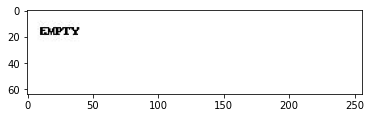

In [71]:
plt.imshow(grd_img[0])

In [72]:
submission = pd.DataFrame({'grd':orig_texts,'prediction':pred_texts})
submission.to_csv('submission.csv',index=False)


In [ ]:
prediction_model.save('recog.h5')